In [2]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [4]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/SBER_MIN60.txt', None, quiet=True)

'SBER_MIN60.txt'

In [5]:
data = pd.read_csv('SBER_MIN60.txt', sep="\t", names=['Datetime', 'Open', 'High', 'Low', 'Close'])

In [9]:
COL_DATE = 'Datetime'
COL_CLOSE = 'Close'

TIME_RANGE = ('2010-09-01 10:00:00.000', '2018-12-31 23:59:00.000')

In [10]:
data.index = pd.to_datetime(data[COL_DATE])
data.drop(columns=COL_DATE, inplace=True)

mask = (data.index >= TIME_RANGE[0]) & (data.index <= TIME_RANGE[1])
data = data[mask]
data

KeyError: ignored

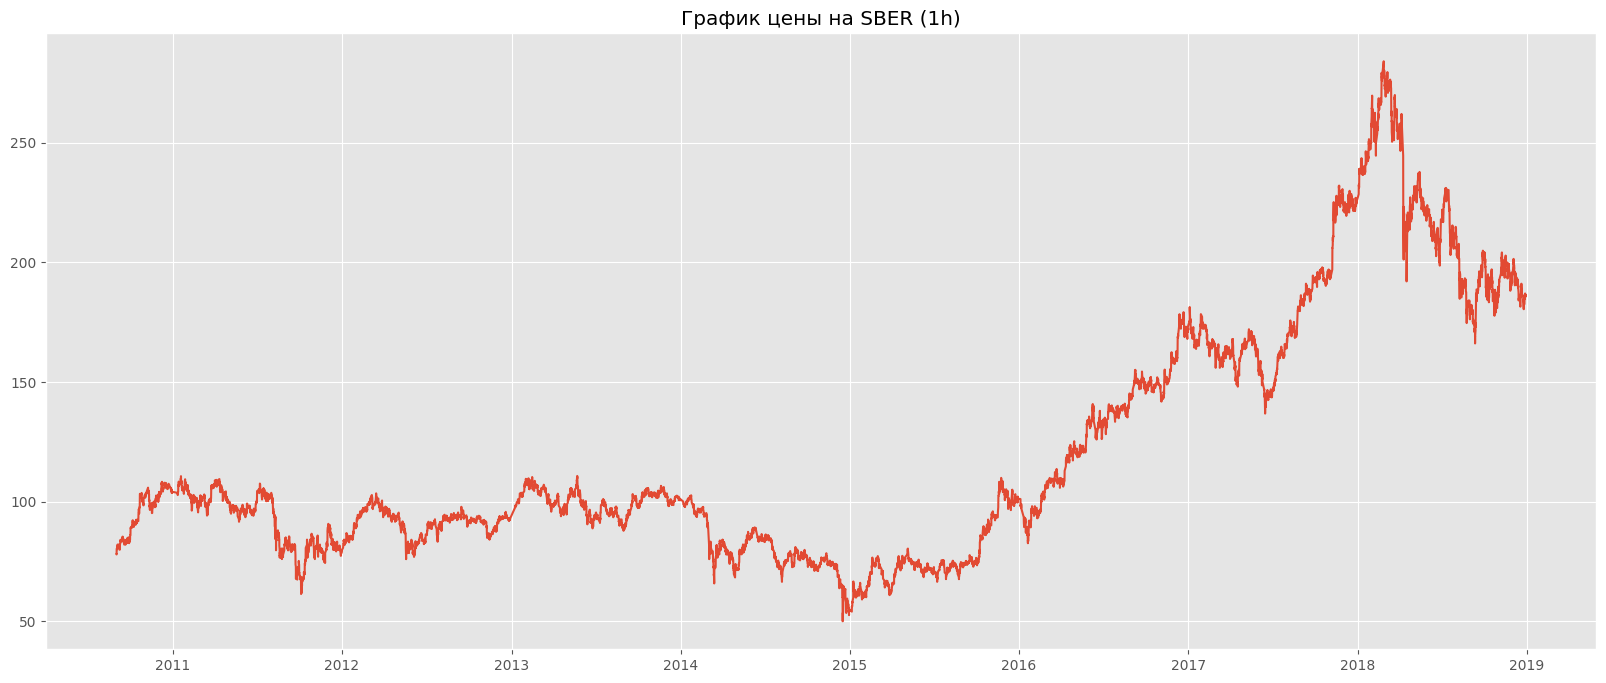

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(data.index, data[COL_CLOSE])
plt.title('График цены на SBER (1h)')
plt.show()

In [ ]:
INDICATOR_DEPTH = 14
SEQ_LEN = 19
PREDICT_LAG = 1
TEST_LEN = 600
CLASS_LABELS = ['Нисходящий/боковой',
                'Восходящий']

In [ ]:
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
        data[indicator_change] = data[COL_CLOSE].pct_change(i)

print(data.shape)
data[:5]

(18818, 18)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14
Datetime,,,,,,,,,,,,,,,,,,
2010-09-01 10:00:00,78.55,78.67,77.94,78.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01 11:00:00,78.04,78.10,77.60,78.00,-0.000513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01 12:00:00,78.00,78.88,77.98,78.88,0.011282,0.010764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01 13:00:00,78.89,79.19,78.80,78.85,-0.000380,0.010897,0.010379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01 14:00:00,78.85,78.99,78.61,78.86,0.000127,-0.000254,0.011026,0.010507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.dropna(inplace=True)

print(data.shape)
data[:5]

(18804, 18)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14
Datetime,,,,,,,,,,,,,,,,,,
2010-09-02 15:00:00,80.87,81.00,80.12,80.40,-0.005566,-0.010340,-0.002853,0.002744,0.001121,-0.000249,0.019270,0.016563,0.018882,0.019528,0.019658,0.019270,0.030769,0.030241
2010-09-02 16:00:00,80.40,81.18,80.20,80.83,0.005348,-0.000247,-0.005047,0.002480,0.008107,0.006475,0.005098,0.024721,0.022000,0.024332,0.024981,0.025111,0.024721,0.036282
2010-09-02 17:00:00,80.83,80.96,80.51,80.85,0.000247,0.005597,0.000000,-0.004801,0.002729,0.008356,0.006724,0.005347,0.024975,0.022253,0.024585,0.025235,0.025365,0.024975
2010-09-02 18:00:00,80.85,81.17,80.14,80.63,-0.002721,-0.002474,0.002861,-0.002721,-0.007509,0.000000,0.005612,0.003985,0.002611,0.022186,0.019471,0.021797,0.022445,0.022575
2010-09-03 10:00:00,80.70,80.79,80.27,80.77,0.001736,-0.000989,-0.000742,0.004602,-0.000989,-0.005785,0.001736,0.007358,0.005728,0.004352,0.023960,0.021242,0.023571,0.024220


In [ ]:
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    indicator_trend = f'Y_{i}'
    data[indicator_trend] = 0.
    data.loc[data[indicator_change] > 0. , indicator_trend] = 1.

print(data.shape)
data[:5]

(18804, 32)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,...,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-09-02 15:00:00,80.87,81.00,80.12,80.40,-0.005566,-0.010340,-0.002853,0.002744,0.001121,-0.000249,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010-09-02 16:00:00,80.40,81.18,80.20,80.83,0.005348,-0.000247,-0.005047,0.002480,0.008107,0.006475,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010-09-02 17:00:00,80.83,80.96,80.51,80.85,0.000247,0.005597,0.000000,-0.004801,0.002729,0.008356,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010-09-02 18:00:00,80.85,81.17,80.14,80.63,-0.002721,-0.002474,0.002861,-0.002721,-0.007509,0.000000,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010-09-03 10:00:00,80.70,80.79,80.27,80.77,0.001736,-0.000989,-0.000742,0.004602,-0.000989,-0.005785,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
x_col = [COL_CLOSE] + [f'Y_{i}' for i in range(1, INDICATOR_DEPTH + 1)]
x_data = data[x_col].values

print(x_data.shape, type(x_data))

(18804, 15) <class 'numpy.ndarray'>


In [ ]:
indicator_name = f'Y_{INDICATOR_DEPTH}'
y_class = data[indicator_name]

y_class[:5]

Datetime
2010-09-02 15:00:00    1.0
2010-09-02 16:00:00    1.0
2010-09-02 17:00:00    1.0
2010-09-02 18:00:00    1.0
2010-09-03 10:00:00    1.0
Name: Y_14, dtype: float64

In [ ]:
y_data = to_categorical(y_class)

print(y_data.shape)
y_data[:5]

(18804, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
x_train_data, y_train_data = x_data[:-TEST_LEN-SEQ_LEN], y_data[:-TEST_LEN-SEQ_LEN]
x_test_data, y_test_data = x_data[-TEST_LEN:], y_data[-TEST_LEN:]

print('train_data: ', x_train_data.shape, y_train_data.shape,
      '\ntest_data:  ', x_test_data.shape, y_test_data.shape,
      '\nОбщая длина:', x_train_data.shape[0] + x_test_data.shape[0])

train_data:  (18185, 15) (18185, 2) 
test_data:   (600, 15) (600, 2) 
Общая длина: 18785


In [ ]:
x_scaler = StandardScaler()
x_scaler.fit(x_train_data)
x_train_data = x_scaler.transform(x_train_data)
x_test_data = x_scaler.transform(x_test_data)

# Проверка результата
print(x_train_data.shape, x_test_data.shape, type(x_train_data))
x_test_data[-1:]

(18185, 15) (600, 15) <class 'numpy.ndarray'>


array([[ 1.40650193,  1.00247764,  0.99271283,  0.99522723,  0.99053149,
         0.98401555,  0.9820689 ,  0.97678842, -1.02331264, -1.02353787,
        -1.02286232,  0.97904815,  0.97431919, -1.02952561, -1.02794036]])

In [ ]:
def split_sequence(x_data, y_data, seq_len, predict_lag):
        x_len = x_data.shape[0] - seq_len - (predict_lag - 1)
        x = [x_data[i:i + seq_len] for i in range(x_len)]
        y = [y_data[i + seq_len + predict_lag - 1] for i in range(x_len)]
        return np.array(x), np.array(y)

In [ ]:

x_train, y_train = split_sequence(x_train_data, y_train_data, SEQ_LEN, PREDICT_LAG)
x_test, y_test = split_sequence(x_test_data, y_test_data, SEQ_LEN, PREDICT_LAG)

print('Массивы x_train и y_train:\t', x_train.shape, y_train.shape)
print('Массивы x_test и y_test:\t', x_test.shape, y_test.shape)

Массивы x_train и y_train:	 (18166, 19, 15) (18166, 2)
Массивы x_test и y_test:	 (581, 19, 15) (581, 2)


In [ ]:

def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(8, 8)):
      y_pred = model.predict(x)
      cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
      cm = np.around(cm, cm_round)


    old_font_size = rcParams['font.size']
    rcParams['font.size'] = 30


    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, cmap='cividis')
    ax.images[-1].colorbar.remove()
    plt.xticks(fontsize=12)
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.yticks(fontsize=12)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()


    rcParams['font.size'] = old_font_size



def train_eval_model(model, x_train, y_train, epoch_list,
                     x_test, y_test, title=''):

    model.summary()


    for epochs, opt in epoch_list:
        model.compile(loss='binary_crossentropy',
                      metrics=['accuracy'],
                      optimizer=opt)


        print(f'Обучение {epochs} эпох')
        history = model.fit(x_train, y_train,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)



        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax1.set_title(f'{title}: График прогресса обучения')
        ax1.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        ax1.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        ax1.set_ylabel('Средняя ошибка')
        ax1.legend()

        ax2.plot(history.history['accuracy'], label='Точность на обучающем наборе')
        ax2.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
        ax2.set_ylabel('Точность классификации')
        ax2.legend()


        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.show()
        eval_model(model, x_test, y_test, title=title)

In [ ]:

input = Input(shape=x_train.shape[1:])
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(SEQ_LEN * 2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(SEQ_LEN, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(SEQ_LEN * 100, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(input, x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 15)]          0         
                                                                 
 flatten (Flatten)           (None, 285)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 4, 285)            0         
 r)                                                              
                                                                 
 conv1d (Conv1D)             (None, 4, 38)             54188     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 38)             0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 76)                0     

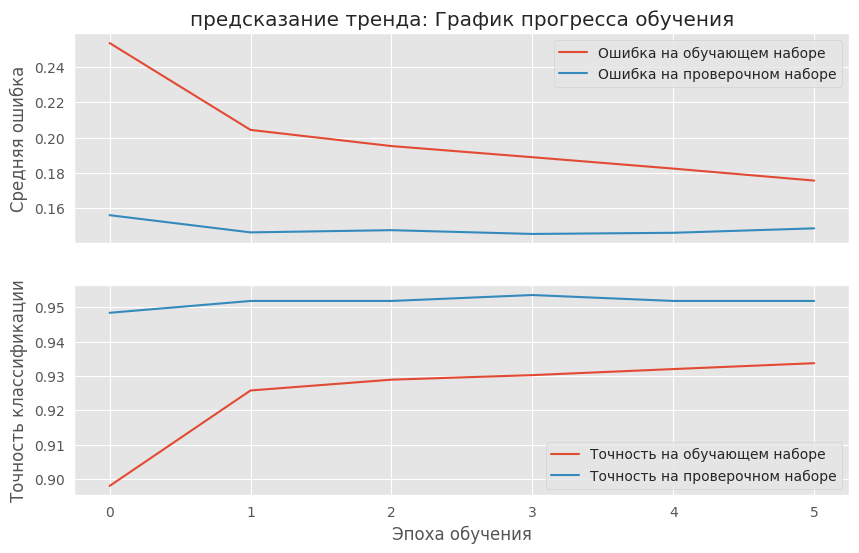

19/19 [==============================] - 0s 5ms/step


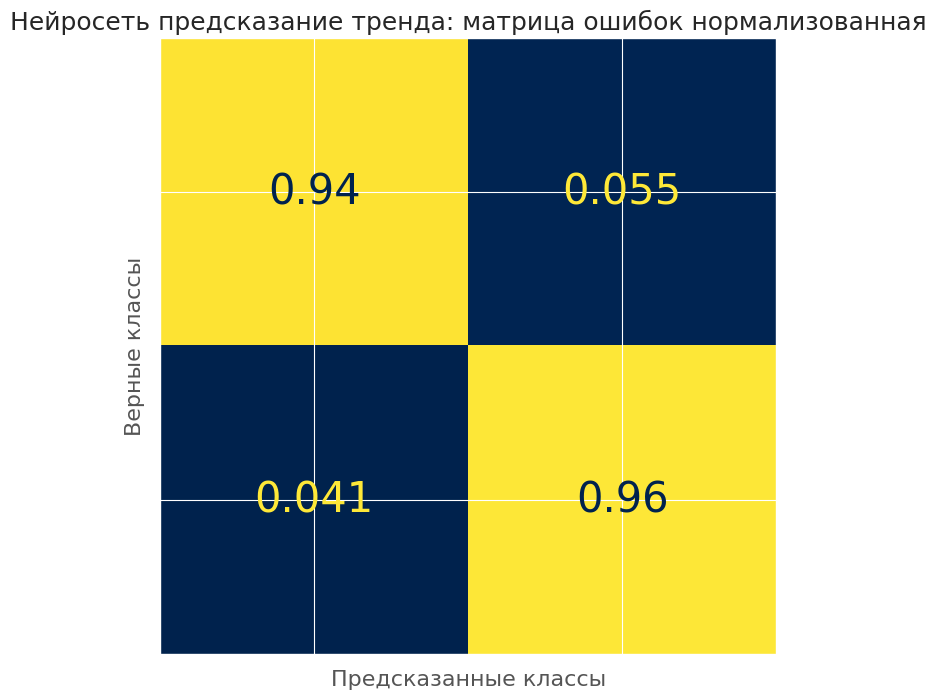

In [ ]:
train_eval_model(model, x_train, y_train, [(6, Adam(learning_rate=1e-04))],
                 x_test, y_test, title='предсказание тренда')

Вывод: данная сеть неплохо справляется с предсказанием тренда роста цены акций. Если поэкспериментировать с архитектурой, возможно, удастся достичь ещё большей точности.